In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm
from assimilation import ExtendedKF, OI, EnKF

### Define functions

In [5]:
def plot_assim_result(result, X_nature, X_obs, rmse, stableidx, result_label=None):
    # plot assimilation result
    ts = np.arange(0, time, dt)
    t_obs = np.arange(0, time, obs_timeintv)

    # plot nature run and assimilation result
    fig, axs = plt.subplots(nrows=4, figsize=(20, 12))
    for i in range(3):
        axs[i].plot(ts, result[i,:], label=result_label)
        axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
        axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
    # plot RMSE and stable index
    axs[3].plot(ts, rmse, c='grey', lw=0.8)
    bool_idx = stableidx > 0
    axs[3].scatter(ts[~bool_idx], rmse[~bool_idx], s=20, c='white')
    axs[3].scatter(ts[bool_idx], rmse[bool_idx], s=20, c=stableidx[bool_idx], cmap='Reds')
    axs[3].scatter(ts[::int(obs_timeintv/dt)], rmse[::int(obs_timeintv/dt)], s=5, marker='x')

    axs[0].set_title('X')
    axs[1].set_title('Y')
    axs[2].set_title('Z')
    axs[3].set_title('RMSE and instability')
    axs[3].set_xlabel('time')

    axs[0].legend()
    plt.tight_layout()
    return fig, axs


def gen_random_obserr(mean, var, size, obs_intv, random_state=None):
    """
    Generate random gaussian observation error.
    
    Parameters:
    ----------
    mean, var: scaler.
        Mean and variance for gaussian distribution.
    size: int.
        The size of output array.
    obs_intv: int.
        The observation interval length in the output array.
    random_state: int.
        Random state. Default is None and it will use np.random.randint.
        
    Return:
    ------
    obs_err: 1-d array.
        The array which observation error occurs every `obs_intv` and others are 0.
        
    EX:
    >>> gen_random_obserr(0, 1, 12, 4)
    array([-0.34889445,  0,  0,  0,  0.98370343,  0,  0,  0,
           0.58092283,  0,  0,  0])
    """
    if random_state is None:
        random_state = np.random.randint(0, 50)
    
    length = np.ceil(size/obs_intv) * obs_intv
    obs_err = np.zeros(int(length)).reshape((-1,obs_intv))
    
    rng = np.random.RandomState(random_state)
    obs_err[:,0] = rng.normal(mean, np.sqrt(var), size=obs_err.shape[0])
    obs_err = obs_err.ravel()[:size]
    return obs_err


def lorenz63_fdm(x0, ts, sigma=None, r=None, b=None):
    """Solve lorenz63 with finit difference method"""  
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
    
    size = ts.size
    dt = ts[1] - ts[0]
    
    x = np.zeros((size,))
    y = np.zeros((size,))
    z = np.zeros((size,))
    x[0] = x0[0]
    y[0] = x0[1]
    z[0] = x0[2]
    
    for i in range(1, size):
        x[i] = x[i-1] + sigma * (y[i-1] - x[i-1]) * dt
        y[i] = y[i-1] + (r*x[i-1] - y[i-1] - x[i-1]*z[i-1]) * dt
        z[i] = z[i-1] + (x[i-1]*y[i-1] - b*z[i-1]) * dt
    
    return np.vstack((x, y, z))


def M(xi, yi, zi, dt, sigma=None, r=None, b=None):
    """tangent linear model for lorenz63_fdm"""
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
    
    M = np.array([
        [1-sigma*dt, sigma*dt, 0],
        [r*dt-zi*dt, 1-dt, -xi*dt],
        [yi*dt, xi*dt, 1-b*dt]
    ])
    return M


def stability_index_lorenz63(x, y, z, sigma=None, r=None, b=None):
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
        
    M = np.array([
        [-sigma, sigma, 0],
        [r-z, -1, -x],
        [y, x, -b]
    ])
    
    eigv, P = np.linalg.eig(M)
    r = eigv.real
    if np.all(r<0):
        # stable case
        return r.sum()
    else:
        # unstable case
        r[r<0] = 0
        return r.sum()

### Create nature run

In [6]:
time = 16
dt = 0.01
ts = np.arange(0, time, dt)
X0 = np.array([[8, 0, 30]]).T
X_nature = lorenz63_fdm(X0.ravel(), ts)
X_nature.shape

(3, 1600)

### Create normal observation

In [31]:
# observation parameters for each variables
obs_mean = [0, 0, 0]
obs_var = [2, 2, 2] 
random_state = [20, 21, 22]

# assimilate observation parameters
obs_timeintv = 0.08
obs_intv = int(obs_timeintv / dt)
cycle_num = int(time / obs_timeintv)

# construct observation error
size = int(time/dt)
X_obs_err = np.zeros((3, size))
for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
    X_obs_err[irow,:] = gen_random_obserr(obsm, obsv, size, obs_intv, rst)
    
X_obs = X_nature + X_obs_err
X_obs = X_obs[:,::obs_intv]

### Initial condition

In [32]:
X_ini = X_nature[:,[0]] + np.array([[50], [40], [60]])

### Assimilation normal observation

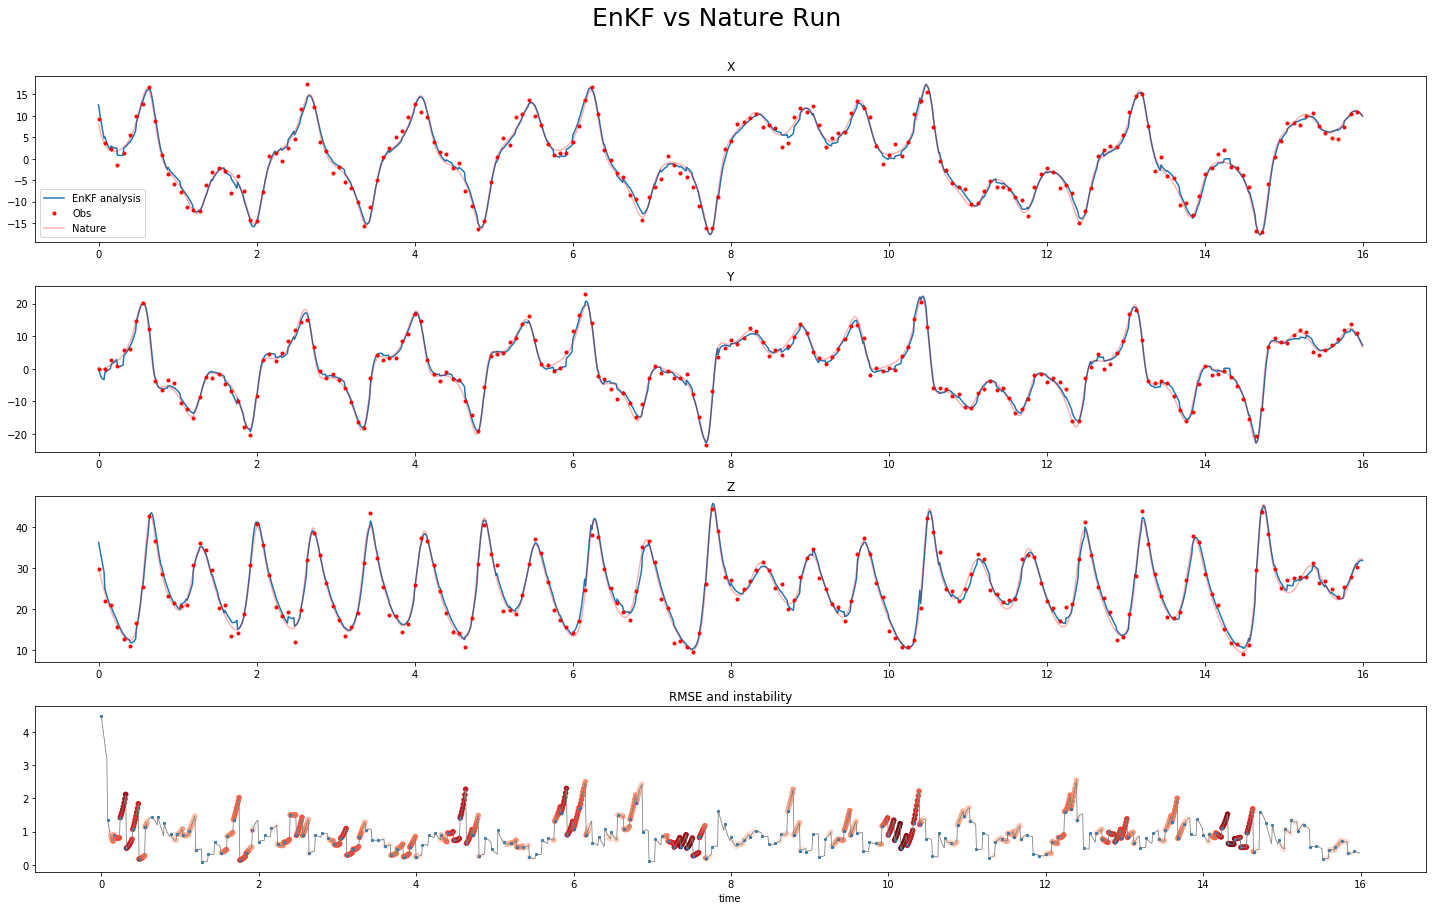

In [33]:
Pb = np.array([
    [ 95.92487549, 108.82721654,  13.52170192],
    [108.82721654, 135.97355097,  18.39642468],
    [ 13.52170192,  18.39642468,  64.98710037]
])
Pb *= 0.2

R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)

# generate initial ensemble
N_ens = 30
X_ens_ini = np.random.multivariate_normal(X_nature[:,0], Pb, size=N_ens).T  # (3, N_ens)
X_ens_ini += 55

enkf_params = {
    'X_ens_ini': X_ens_ini, 
    'obs': X_obs, 
    'obs_interv': 8, 
    'R': R, 
    'H_func': None, 
    'alpha': 0.3,
    'inflat': 1.4
}

enkf = EnKF(lorenz63_fdm, dt)
enkf.set_params(**enkf_params)
enkf.cycle()
enkf.analysis
ens_mean = enkf.analysis.mean(axis=0)

# calculate RMSE and stable index
rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
stableidx = []
for x in ens_mean.T:
    stableidx.append(stability_index_lorenz63(*x))
stableidx = np.array(stableidx)

# plot
fig, axs = plot_assim_result(ens_mean, X_nature, X_obs, rmse_enkf, stableidx, 'EnKF analysis')
fig.suptitle('EnKF vs Nature Run', fontsize=25, y=1.05);

### Bias observation

In [153]:
ex_obs_dict = {}
ex_mean = [0.05, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

for ex_m in ex_mean:
    print(ex_m)
    obs_mean = [ex_m for _ in range(3)]
    obs_var = [2, 2, 2]
    random_state = [29, 21, 36]
    
    obs_timeintv = 0.08
    obs_intv = int(obs_timeintv / dt)
    cycle_num = int(time / obs_timeintv)
    
    size = int(time/dt)
    X_obs_err = np.zeros((3, size))
    for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
        X_obs_err[irow,:] = gen_random_obserr(obsm, obsv, size, obs_intv, rst)

    print(X_obs_err[:,::8].mean(axis=1))
    ex_obs = X_nature + X_obs_err
    ex_obs = ex_obs[:,::obs_intv]
    
    key = f'{ex_m:4.2f}'
    ex_obs_dict[key] = ex_obs

0.05
[0.05518655 0.05047051 0.08691752]
0.15
[0.15518655 0.15047051 0.18691752]
0.2
[0.20518655 0.20047051 0.23691752]
0.25
[0.25518655 0.25047051 0.28691752]
0.3
[0.30518655 0.30047051 0.33691752]
0.35
[0.35518655 0.35047051 0.38691752]
0.4
[0.40518655 0.40047051 0.43691752]


In [154]:
ex_obs_dict['0.05'].shape

(3, 200)

### assimilation bias observation

[[ 7.45959111e+00  4.41103911e+00  4.59610899e+00 -1.13410556e+00
   3.82599884e+00]
 [-2.34885464e-02  2.34178561e-02  2.76112143e+00  7.88770306e-01
   5.67368098e+00]
 [ 3.10065928e+01  2.63066630e+01  1.88472636e+01  1.76303848e+01
   1.26106952e+01]]
[[ 7.55959111  4.51103911  4.69610899 -1.03410556  3.92599884]
 [ 0.07651145  0.12341786  2.86112143  0.88877031  5.77368098]
 [31.10659281 26.40666299 18.94726362 17.73038478 12.71069521]]
[[ 7.60959111  4.56103911  4.74610899 -0.98410556  3.97599884]
 [ 0.12651145  0.17341786  2.91112143  0.93877031  5.82368098]
 [31.15659281 26.45666299 18.99726362 17.78038478 12.76069521]]
[[ 7.65959111  4.61103911  4.79610899 -0.93410556  4.02599884]
 [ 0.17651145  0.22341786  2.96112143  0.98877031  5.87368098]
 [31.20659281 26.50666299 19.04726362 17.83038478 12.81069521]]
[[ 7.70959111  4.66103911  4.84610899 -0.88410556  4.07599884]
 [ 0.22651145  0.27341786  3.01112143  1.03877031  5.92368098]
 [31.25659281 26.55666299 19.09726362 17.8803847

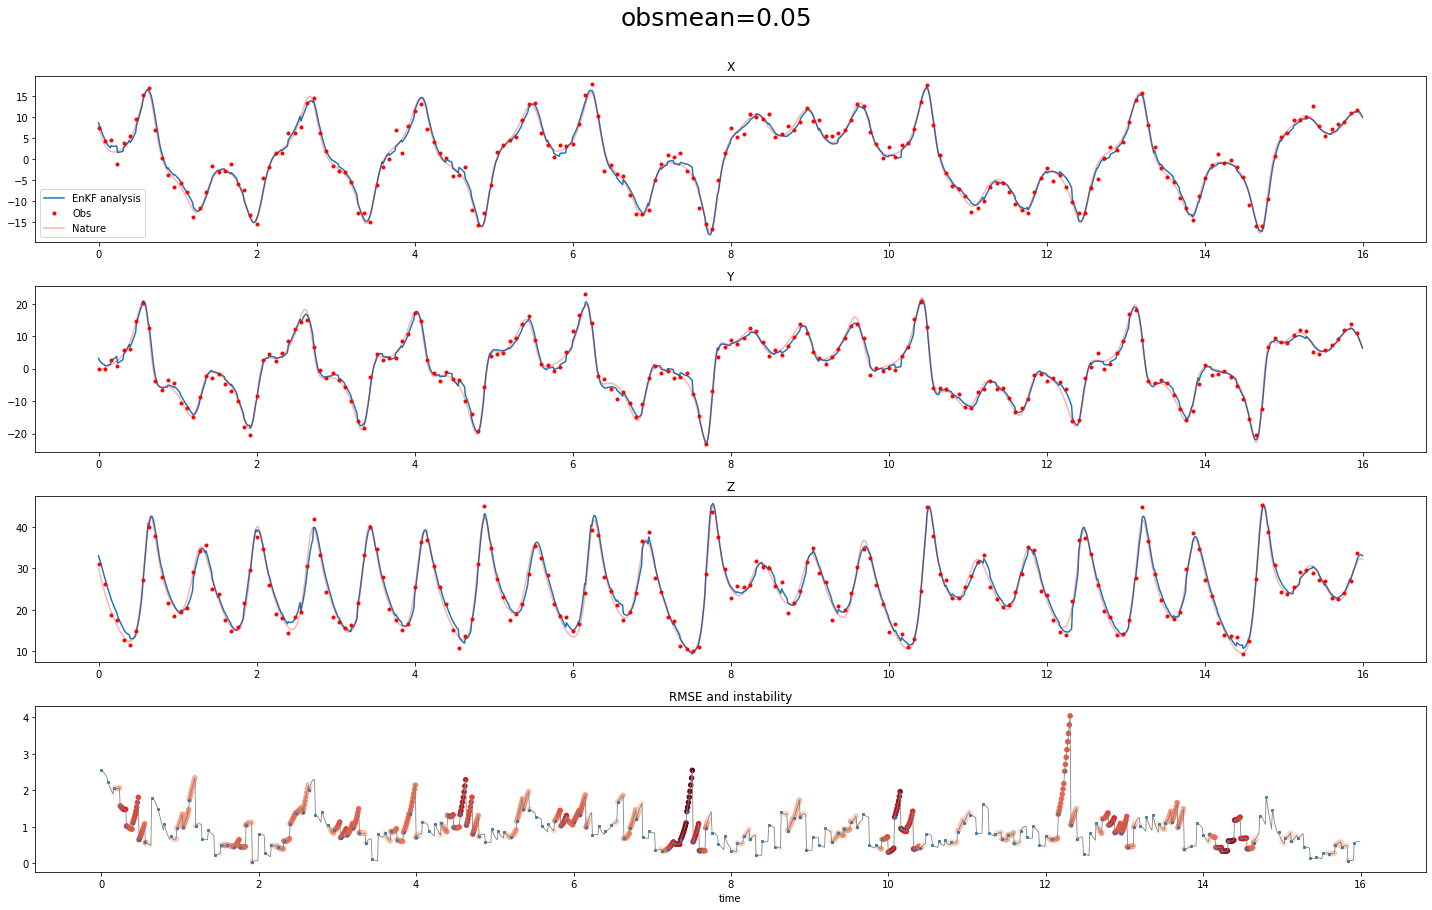

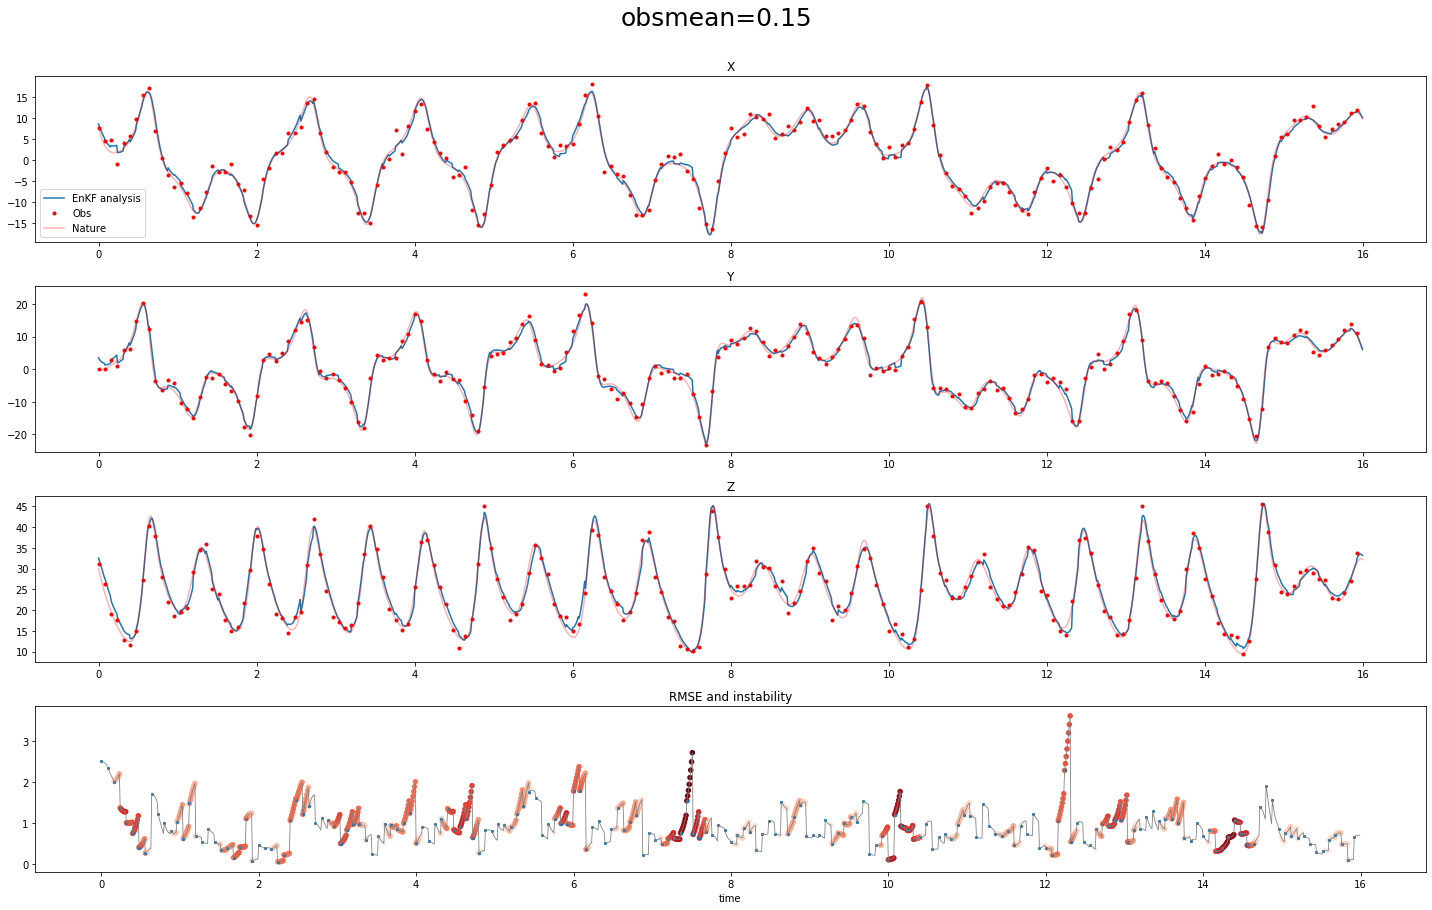

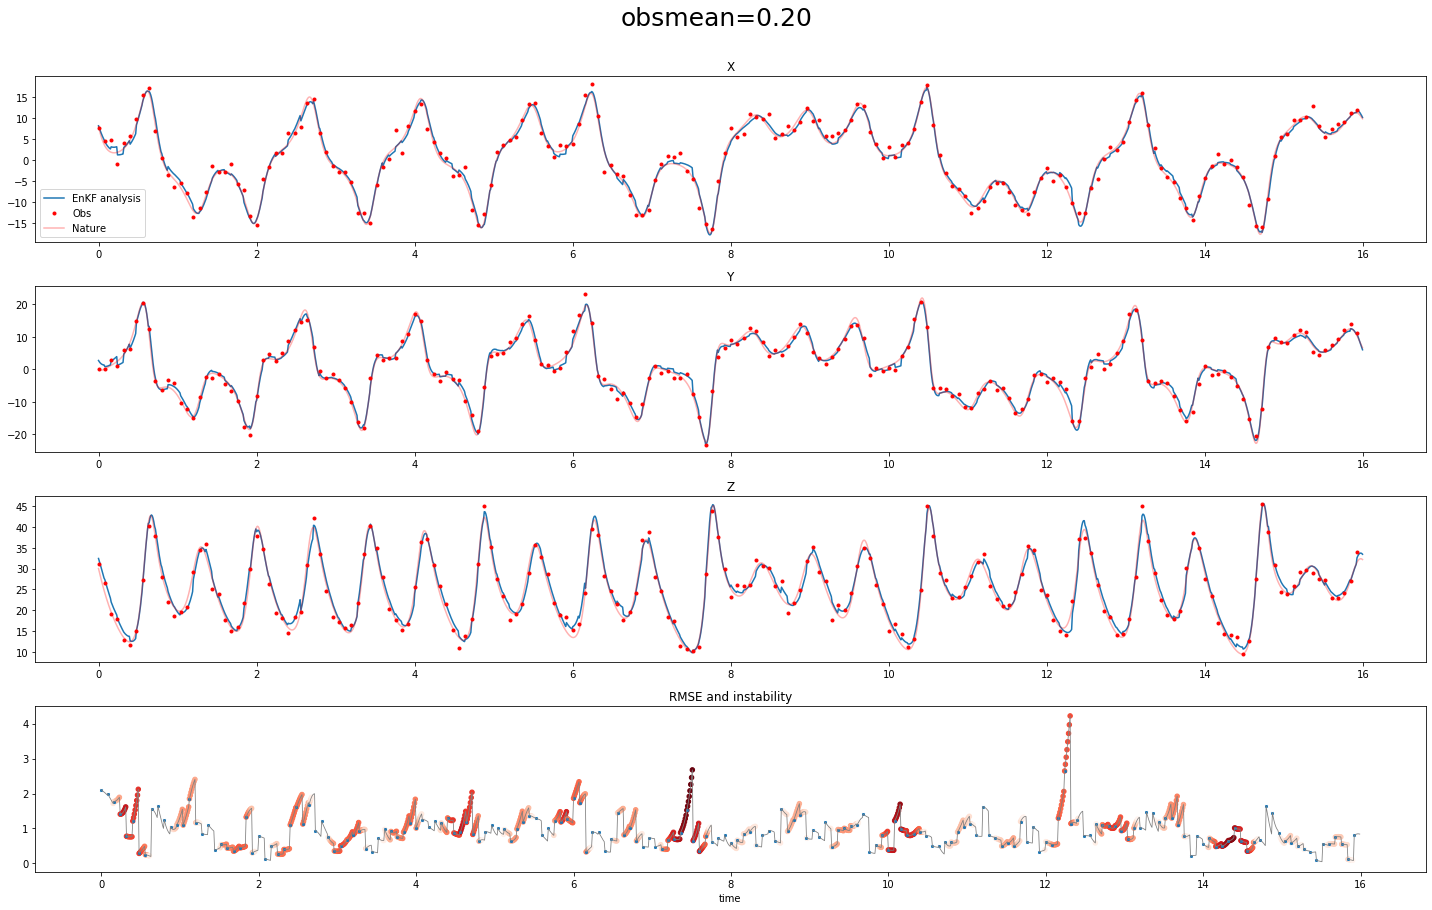

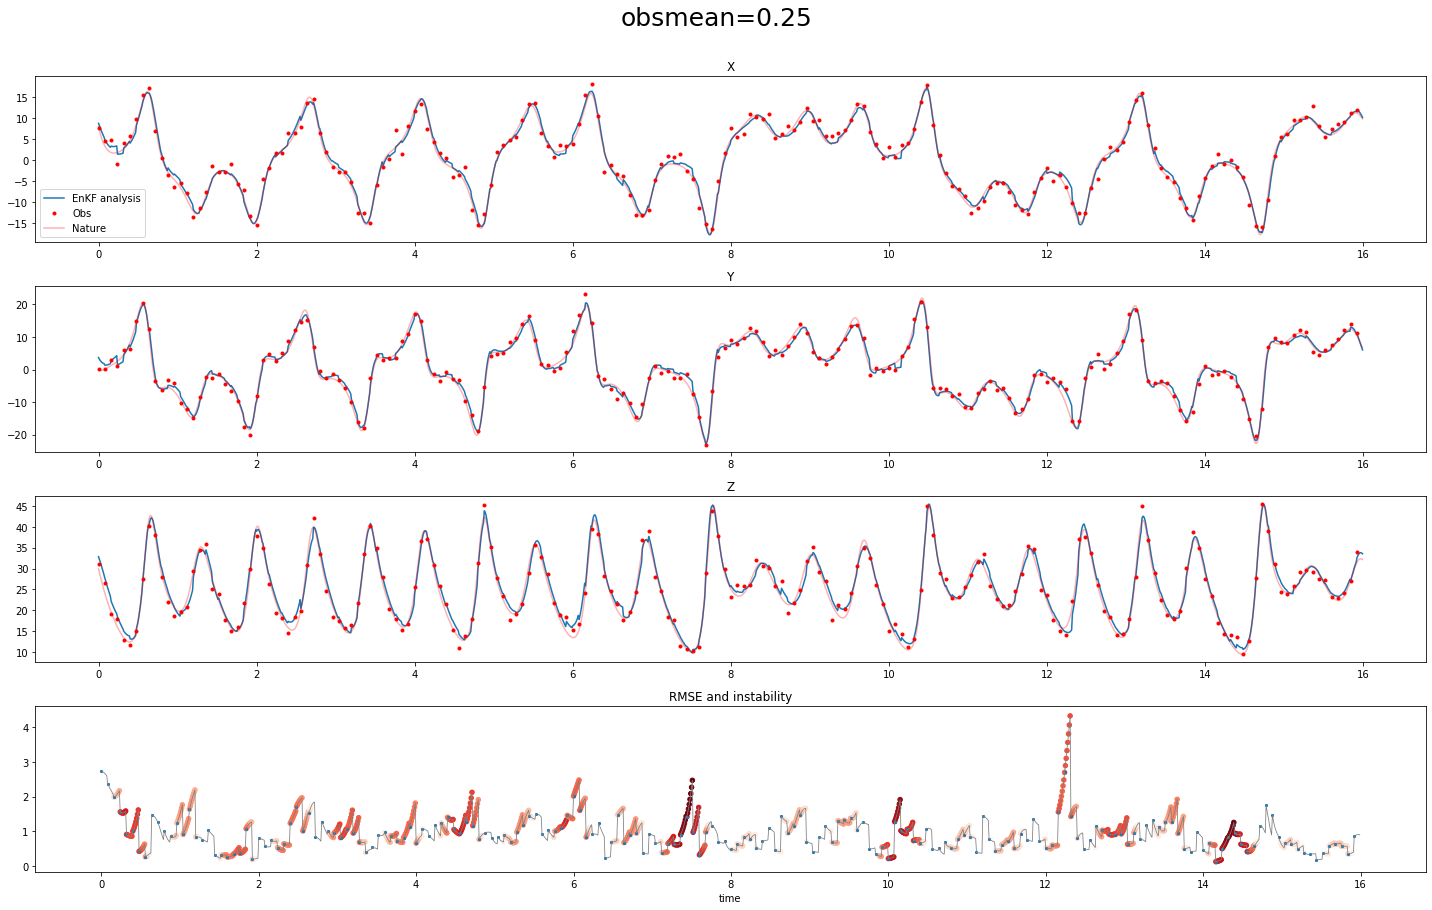

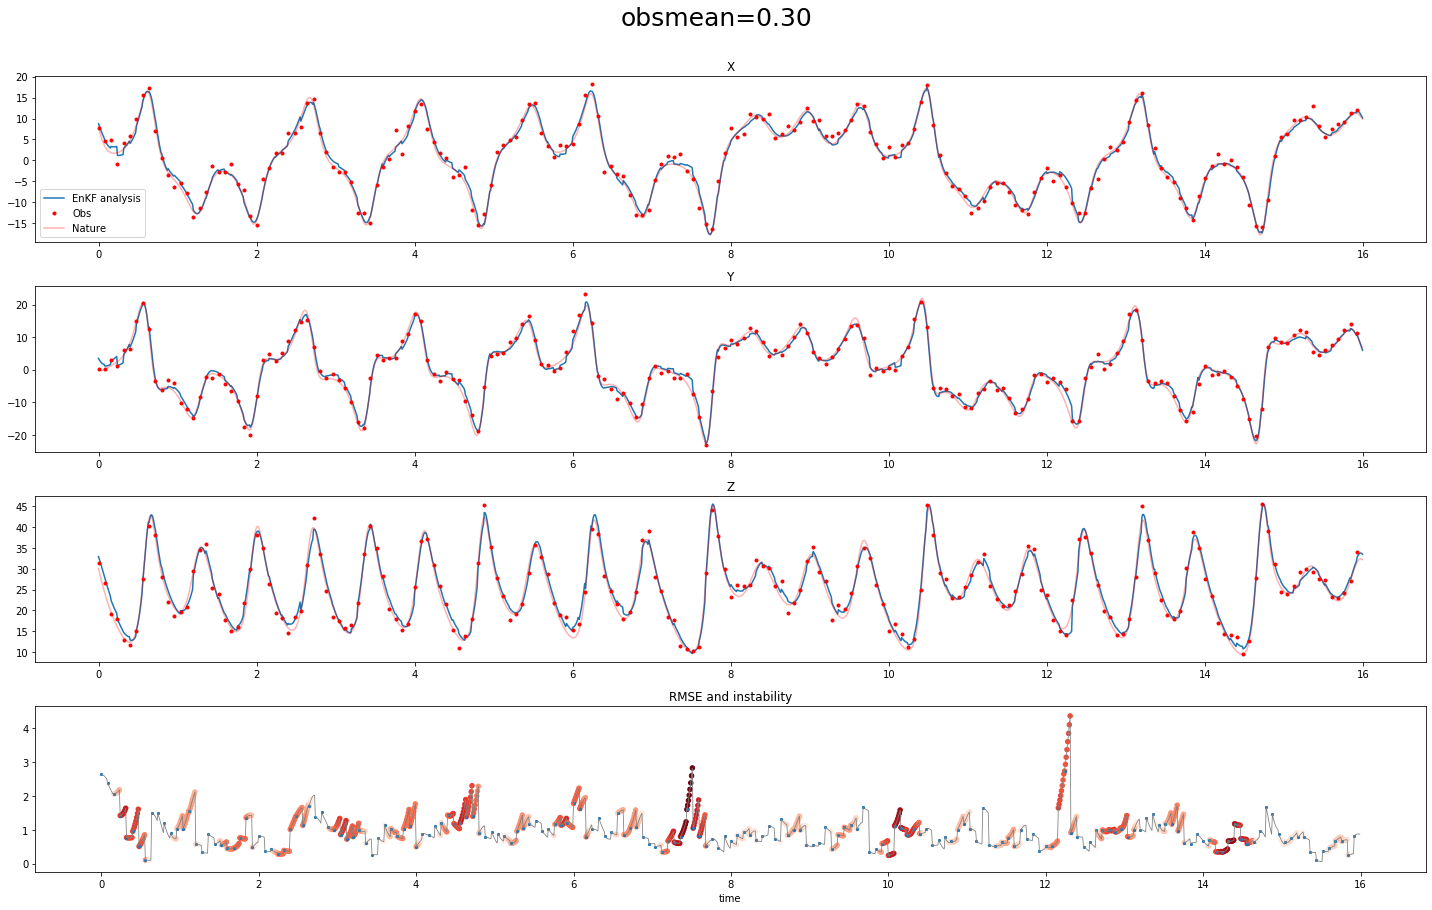

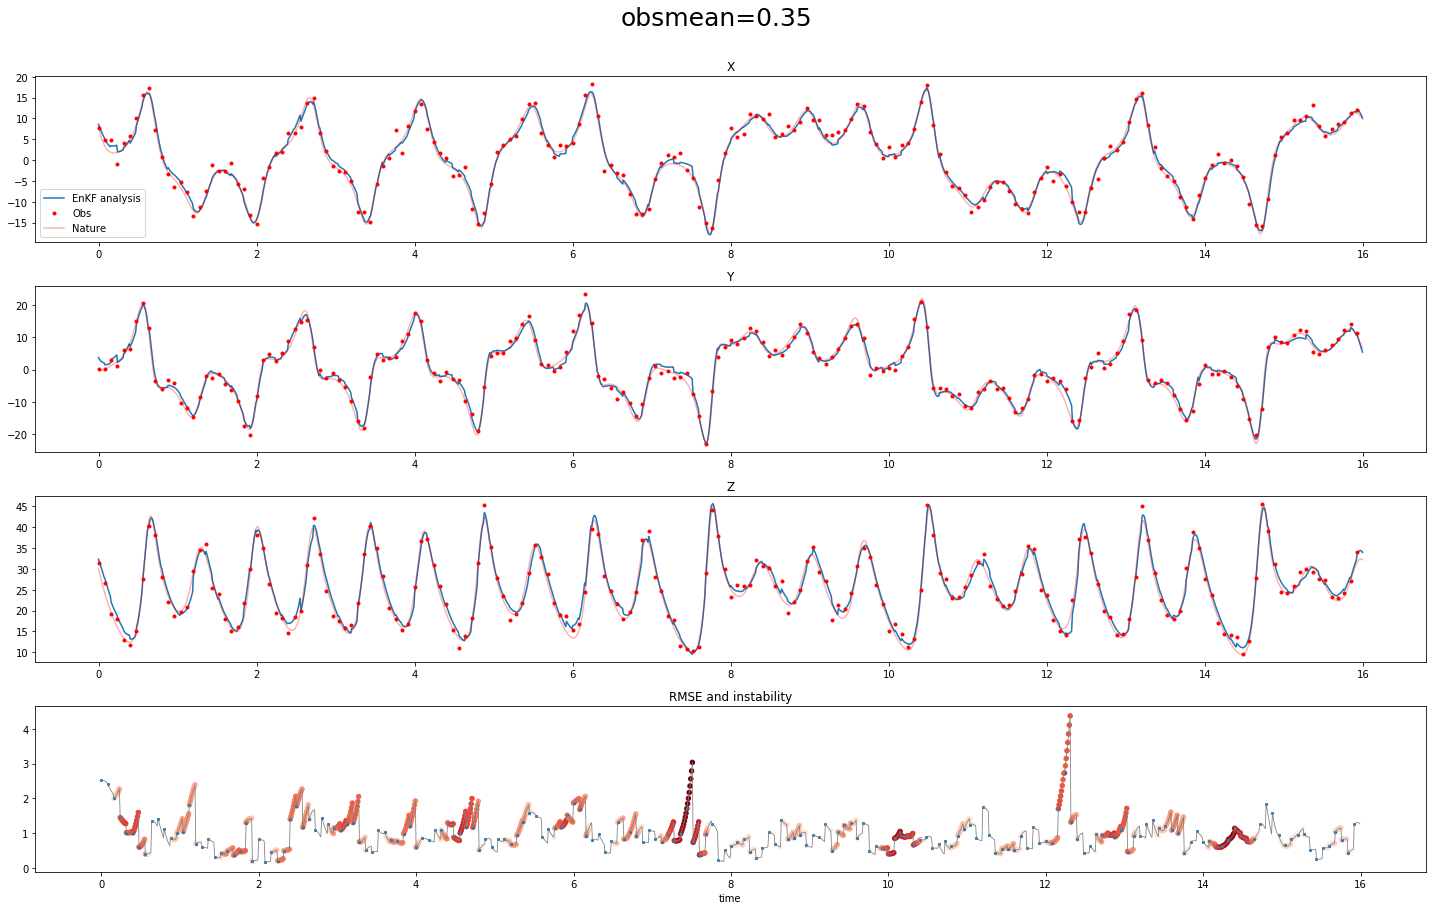

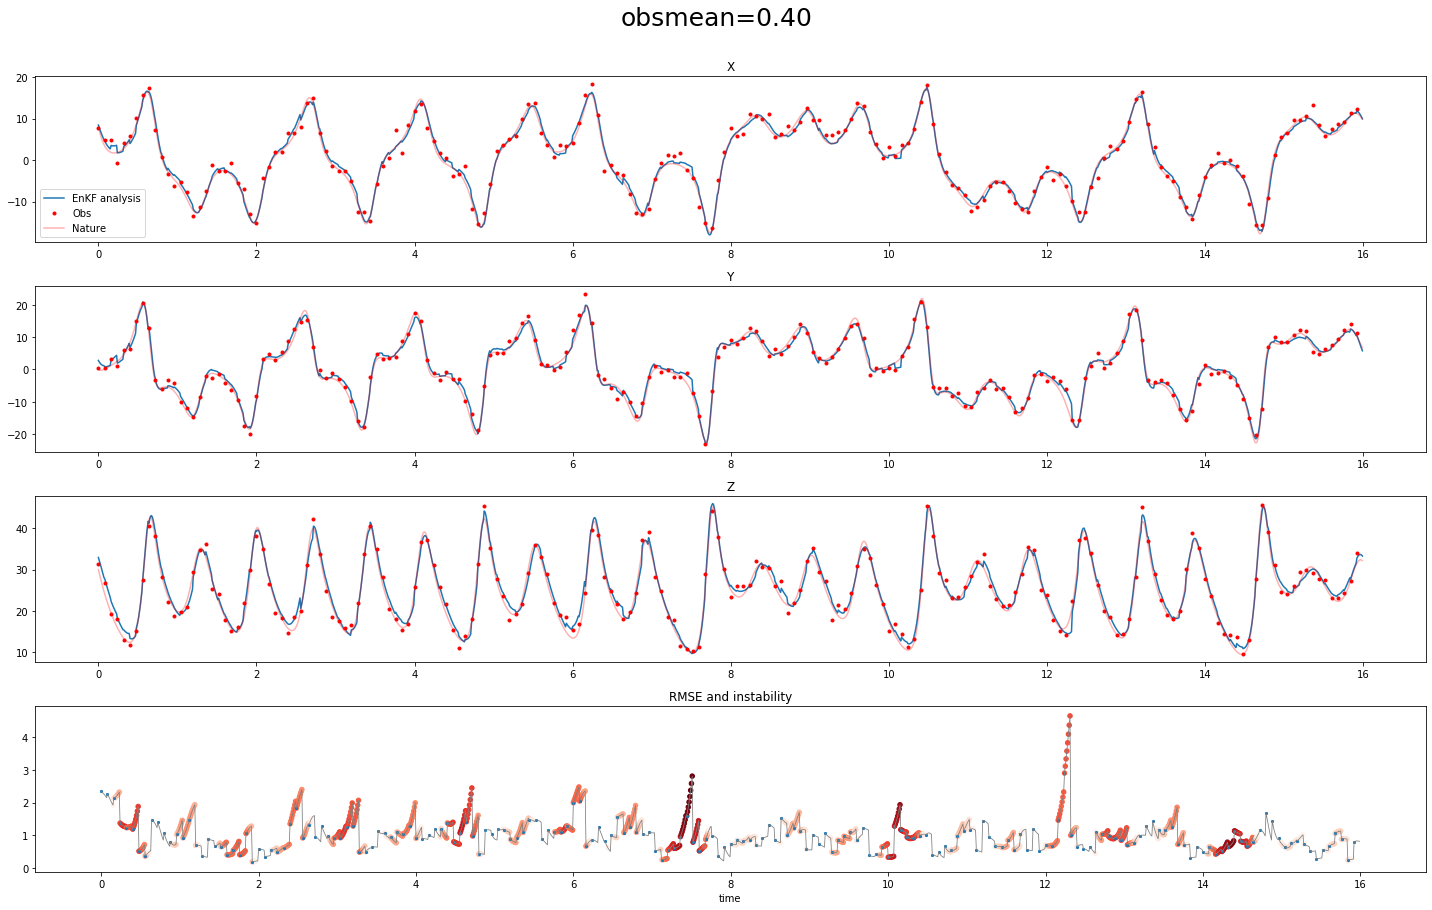

In [158]:
for obsm in [0.05, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:
    key = f'{obsm:4.2f}'
    obs = ex_obs_dict[key]
    print(obs[:,:5])

    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    enkf.analysis
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
    stableidx = []
    for x in ens_mean.T:
        stableidx.append(stability_index_lorenz63(*x))
    stableidx = np.array(stableidx)

    # plot
    fig, axs = plot_assim_result(ens_mean, X_nature, obs, rmse_enkf, stableidx, f'EnKF analysis')
    fig.suptitle(f'obsmean={key}', fontsize=25, y=1.05);